In [169]:
import bezier
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.ndimage import rotate
from matplotlib.patches import Arc

In [170]:
# Rotates the nodes by the provided angle (in degrees)
def rotateNodes(nodes, angle):
    # convert angle from degrees to radians
    theta = np.radians(angle)
    # define rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    A = np.array([[c, -s], [s, c]])
    # apply rotation
    rot_nodes = nodes.transpose().dot(A).transpose()
    return rot_nodes

In [171]:
# Splits a bezier curve and splices them together with an arc
# The second half of the bezier curve will be rotated and translated
#     to be tangent with the arc
def bendCurve():
    
    # original bezier curve
    nodes = np.asfortranarray([
        [0.0, 0.3, 0.5, 1.0, 1.5],
        [0.0, 0.5, -0.2, 0.5, 0.2],
    ])
    curve = bezier.Curve.from_nodes(nodes)
    
    # plot original bezier curve, nodes, and polygon
    seaborn.set()
    ax = curve.plot(num_pts=256, color='purple')
    lines = ax.plot(
        nodes[0, :], nodes[1, :],
        marker='.', linestyle='-', color='black')
    ax.set_xlim(-0.05, 1.6)
    ax.set_ylim(-0.4, 0.6)
    
    # LEFT SIDE
    split1 = 0.5
    left = curve.specialize(0, split1)
    collisionPoint = left.nodes[:, -1]
    
    
    
    # MAKE THE ARC
    # first, define the parameters
    
    # radius (given)
    radius = 0.2
    
    # center (determined by radius and curve)
    direction = 1    # center to the right of curve ==> 1, to the left of curve ==> -1
    tangent1 = left.nodes[:, -1] - left.nodes[:, -2]
    tangent1 = tangent1 / np.linalg.norm(tangent1) # tangent with magnitude 1
    rotMatrix = direction * np.array([[0, -1], [1, 0]]) # rotate 90 degrees
    normal = tangent1.transpose().dot(rotMatrix).transpose()
    center = left.nodes[:, -1] + radius * normal
    
    # start angle (determined by contact point and center)
    # note: angles measured in degrees counterclockwise from vector [1, 0]
    u = collisionPoint - center
    theta1 = np.arctan2(u[1], u[0]) * 180 / np.pi
    
    # end angle (determined by arc length, contact point, and center)
    split2 = 0.7
    middle = curve.specialize(split1, split2)    
    arcLength = middle.length
    arcAngle = 180 * arcLength / (np.pi * radius)
    theta2 = theta1 - direction * arcAngle
    
    # make the arc
    arc = None
    # If coil is unraveling to the RIGHT, the arc should be drawn
    # from theta2 (contactPoint) to theta1 (collisoinPoint)
    if direction == 1: 
        arc = Arc((center[0], center[1]), 2*radius, 2*radius,
              theta1=theta2, theta2=theta1, ec='purple', lw=2)
    # If coils is unraveling to the LEFT, the arc should be drawn
    # from theta1 (collisionPoint) to theta2 (contactPoint)
    else:
        arc = Arc((center[0], center[1]), 2*radius, 2*radius,
              theta1=theta1, theta2=theta2, ec='purple', lw=2)

    
    # ADJUST RIGHT SIDE
    right = curve.specialize(split2, 1)
    rNodes = right.nodes

    # get the contact point
    transVec = np.array([np.cos(theta2 * np.pi / 180), np.sin(theta2 * np.pi / 180)])
    contactPoint = center + radius * transVec
    
    # rotate nodes
    # rotation angle must account for contact angle (theta2) and 
    # the initial tangent to the curve (tangent2)
    targetAngle = theta2 + 90 * direction
    tangent2 = rNodes[:, 1] - rNodes[:, 0]
    tangent2 = tangent2 / np.linalg.norm(tangent2) # tangent with magnitude 1
    tangent2Angle = np.arctan2(tangent2[1], tangent2[0]) * 180 / np.pi
    rotAngle = targetAngle + tangent2Angle
    rNodes = rotateNodes(rNodes, rotAngle)
    
    # translate nodes to the contact point
    rNodes = rNodes.transpose()
    rNodes = rNodes + (contactPoint - rNodes[0,:])
    rNodes = rNodes.transpose()
    
    # make a new curve on these nodes
    right = bezier.Curve.from_nodes(rNodes)
    
    
    # PLOT RESULTS
    seaborn.set()
    # left side
    ax = left.plot(num_pts=256, color='red')
    ax.plot(
        left.nodes[0, :], left.nodes[1, :],
        marker='.', linestyle='-', color='orange')
    ax.plot(
        collisionPoint[0], collisionPoint[1], marker='o', color='red')
    # arc
    ax.plot(center[0], center[1], marker='o', color='purple')
    ax.add_patch(arc)
    ax.plot(contactPoint[0], contactPoint[1], marker='o', color='blue')
    # right side
    _ = right.plot(num_pts=256, ax=ax, color='blue')
    _.plot(
        right.nodes[0, :], right.nodes[1, :],
        marker='.', linestyle='-', color='green')
    
    ax.set_aspect('equal')
    plt.show()

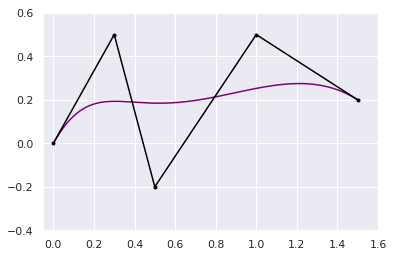

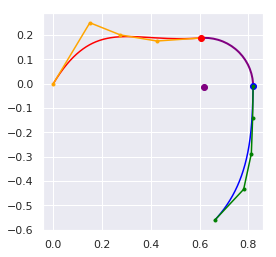

In [172]:
if __name__ == "__main__":
    bendCurve()